# Introduction

## About the data:
**According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.**

**The data is imbalanced, there are 249 person are patients and 4861 aren't**

## The Algorithms used:
1. Random forest
2. XGBoost
3. SVC


# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scikitplot as skplt

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

# Load the data

In [2]:
data = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### A quick look at the data

In [6]:
cols = list(data.columns)
cols_data=cols[1:]

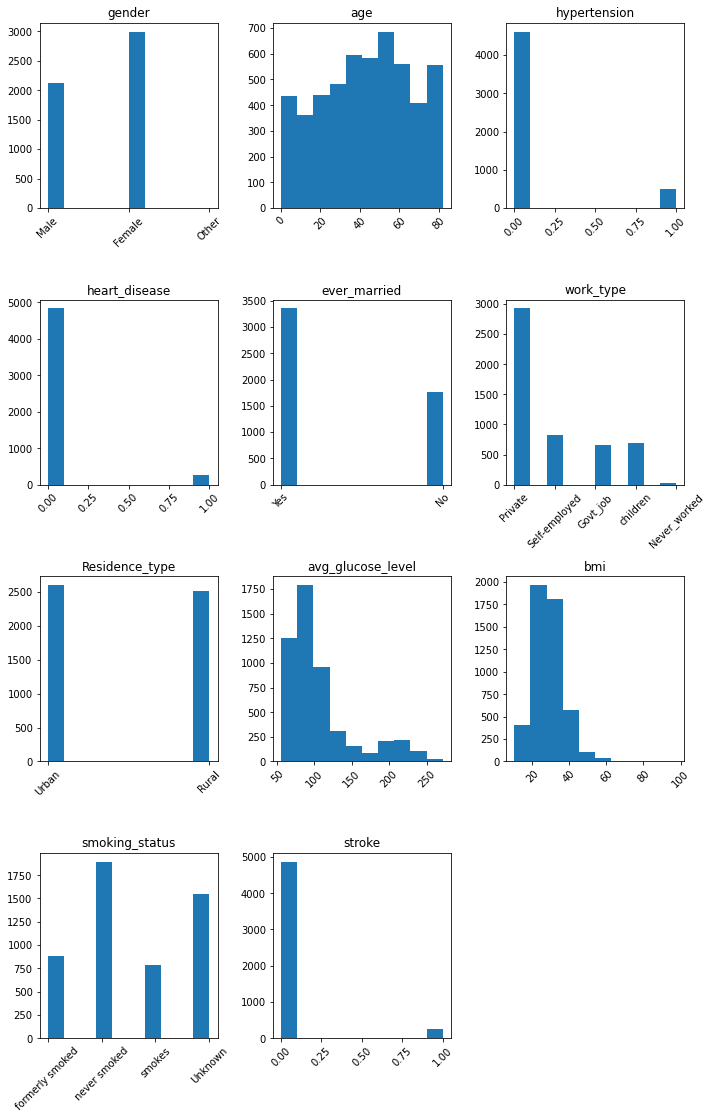

In [7]:
plt.figure(figsize=(10,30))
for i in range(len(cols_data)):
    plt.subplot(8,3,i+1)
    plt.title(cols_data[i])
    plt.xticks(rotation=45)
    plt.hist(data[cols_data[i]])
    
plt.tight_layout()

In [8]:
data['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

### drop the row has other label in gender

In [9]:
data[data['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [10]:
data = data.drop(data[data['gender']=='Other'].index)

In [11]:
data[data['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


# Deal with Missing

In [12]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [13]:
print(data['bmi'].mean())
print(data['bmi'].median())

28.894559902200488
28.1


In [14]:
bmi_mean=data['bmi'].mean()
data['bmi']=data['bmi'].fillna(bmi_mean)

In [15]:
data['bmi'].isnull().sum()

0

# EDA

### Pie chart for stroke or no stroke

In [16]:
# counting the number of passengers who are satisfied and who Dissatisfied 
pie_df=pd.DataFrame(data.groupby('stroke')['stroke'].count())
pie_df

,stroke
stroke,
0,4860
1,249


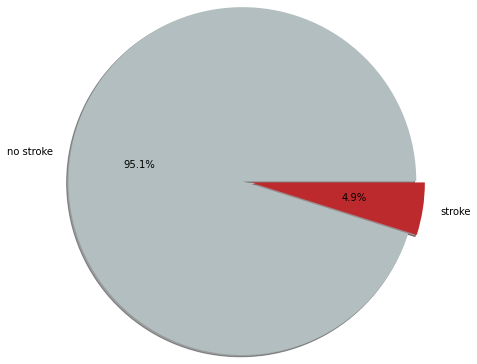

In [17]:
colors = ['#B2BEBF','#BD2A2E']
plt.pie(pie_df['stroke'],labels=['no stroke','stroke'],
        autopct='%.1f%%',colors=colors,radius=2,explode = (0, 0.1),shadow=True)
plt.show()

## Histogram

### Avg. Glucose Level

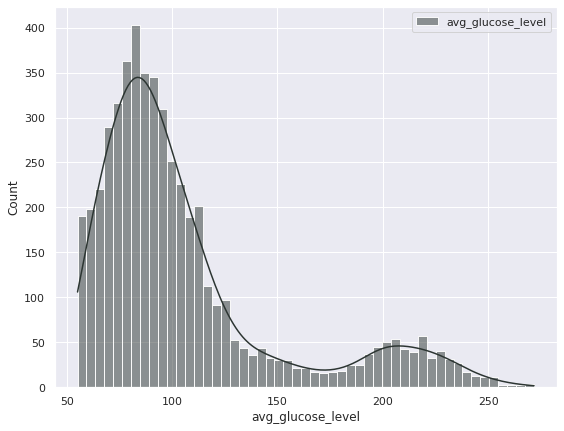

In [18]:
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(9,7))
sns.histplot(data['avg_glucose_level'], color="#2C3532", label="avg_glucose_level", kde= True)
plt.legend()

### BMI

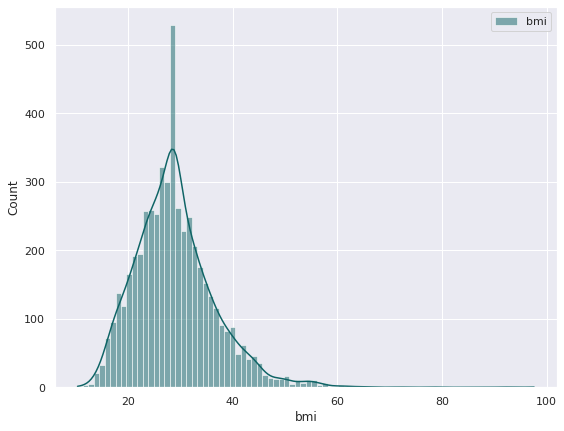

In [19]:
fig = plt.figure(figsize=(9,7))
sns.histplot(data['bmi'], color="#0F6466", label="bmi", kde= True)
plt.legend()

### Stroke vs No Stroke by bmi

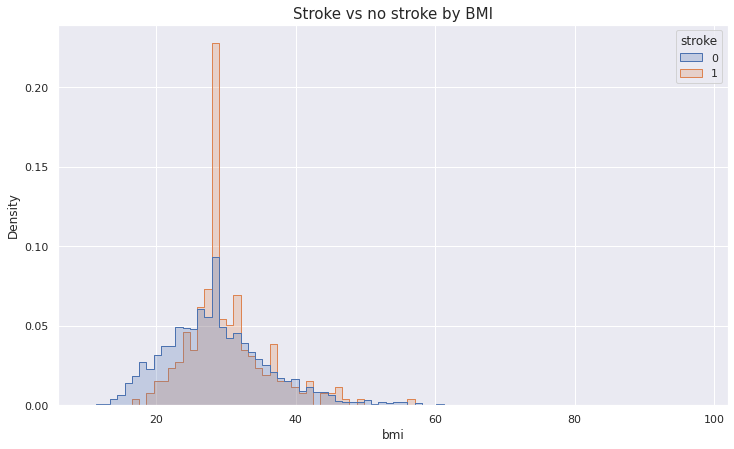

In [20]:
plt.figure(figsize=(12,7))
sns.histplot(
    data, x="bmi", hue="stroke",
    element="step",
    stat="density", common_norm=False,
)
plt.title('Stroke vs no stroke by BMI', fontsize=15)
plt.show()

*The density of overweight people who suffered a stroke is more.*

### Stroke vs No Stroke by Avg. Glucose Level

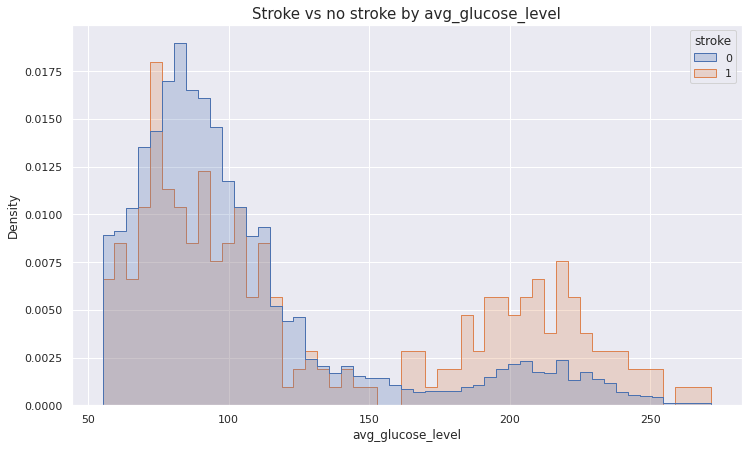

In [21]:
plt.figure(figsize=(12,7))
sns.histplot(
    data, x="avg_glucose_level", hue="stroke",
    element="step",
    stat="density", common_norm=False,
)
plt.title('Stroke vs no stroke by avg_glucose_level', fontsize=15)
plt.show()

*The density of people having glucose level less than 100 suffered stroke more.*

### Stroke vs No Stroke by Age

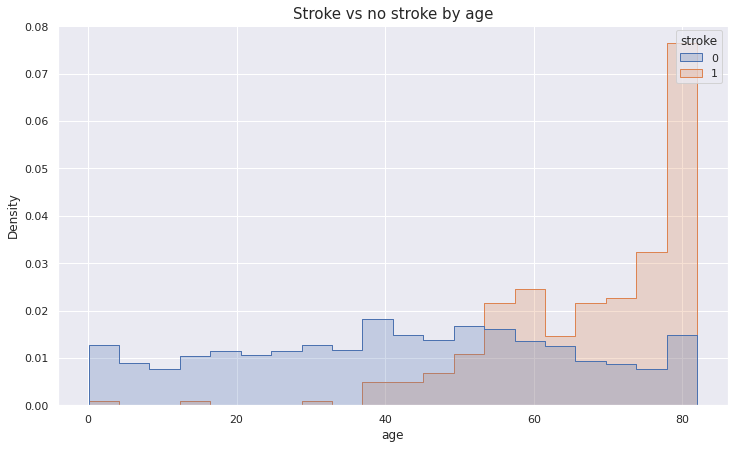

In [22]:
plt.figure(figsize=(12,7))
sns.histplot(
    data, x="age", hue="stroke",
    element="step",
    stat="density", common_norm=False,
)
plt.title('Stroke vs no stroke by age', fontsize=15)
plt.show()

*The density of people having age above 50 suffered stroke more.*

### BMI vs Age classified by the gender
#### The normal bmi is 25 so who has bmi more than 25

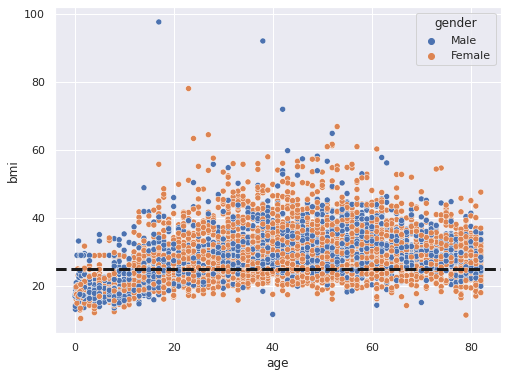

In [23]:
plt.figure(figsize=(8,6))
fig = sns.scatterplot(data=data, x="age", y="bmi", hue='gender')
fig.axhline(y= 25, linewidth=3, color='k', linestyle= '--')
plt.show()

*There are a lot of people with a BMI above 25 who are overweight and obese.*

### Avg. Glucose Level vs Age classified by the gender
#### The normalAvg. Glucose Level is 150, so who has Avg. Glucose Level more than 150

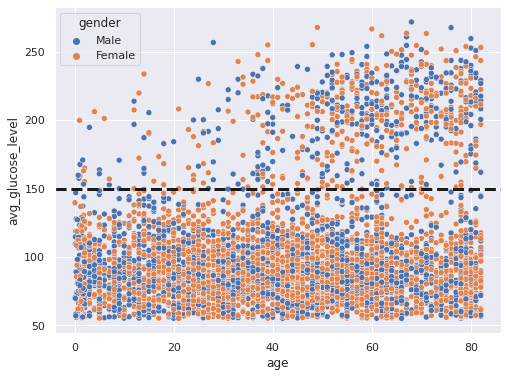

In [24]:
plt.figure(figsize=(8,6))
fig = sns.scatterplot(data=data, x="age", y="avg_glucose_level", hue='gender')
fig.axhline(y= 150, linewidth=3, color='k', linestyle= '--')
plt.show()

*The people who have glucose level above 150 are relatively less as compared to ones below. So, we can say that people above 150 might be suffering from diabetes.*

---

# Data preprocessing

### drop unimportant column

In [25]:
data.drop('id',axis=1,inplace=True)

### Handling Text and Categorical Attributes

In [26]:
obj_cols=['gender', 'ever_married', 'Residence_type']

lb=LabelEncoder()

for i in obj_cols:
    print(f"Value Counts of column:{i}")
    print(data.loc[:,i].value_counts())
    data[i] = lb.fit_transform(data[i])
    print("The classes which labeled from 0 are: ",lb.classes_,end="\n===========================================\n")
    

Value Counts of column:gender
Female    2994
Male      2115
Name: gender, dtype: int64
The classes which labeled from 0 are:  ['Female' 'Male']
Value Counts of column:ever_married
Yes    3353
No     1756
Name: ever_married, dtype: int64
The classes which labeled from 0 are:  ['No' 'Yes']
Value Counts of column:Residence_type
Urban    2596
Rural    2513
Name: Residence_type, dtype: int64
The classes which labeled from 0 are:  ['Rural' 'Urban']


In [27]:
data=pd.get_dummies(data)

In [28]:
data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.60000,1,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.89456,1,0,0,0,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.50000,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.40000,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.00000,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,1,83.75,28.89456,0,0,0,1,0,0,0,0,1,0
5106,0,81.0,0,0,1,1,125.20,40.00000,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,0,82.99,30.60000,0,0,0,0,1,0,0,0,1,0
5108,1,51.0,0,0,1,0,166.29,25.60000,0,0,0,1,0,0,0,1,0,0


## Scaling and split the data 

In [29]:
sc=MinMaxScaler()
data[['bmi', 'avg_glucose_level', 'age']] = sc.fit_transform(data[['bmi', 'avg_glucose_level', 'age']])

In [30]:
x_data = data.drop("stroke" , axis = 1).values
y_data = data["stroke"]

---

# Imbalanced Data

What is going on in our models when we train on an imbalanced dataset? As you might have guessed, the reason we get 90% accuracy on an imbalanced data (with 90% of the instances in Class-1) is because our models look at the data and cleverly decide that the best thing to do is to always predict “Class-1” and achieve high accuracy.

**To Combat Imbalanced Training Data:** 

**1- Try Resampling Your Dataset:** You can change the dataset that you use to build your predictive model to have more balanced data. This change is called sampling your dataset and there are two main methods that you can use to even-up the classes: You can add copies of instances from the under-represented class called over-sampling (or more formally sampling with replacement), or you can delete instances from the over-represented class, called under-sampling.

**2- Use the right evaluation metrics:** Applying inappropriate evaluation metrics for model generated using imbalanced data can be dangerous. Imagine our training data is the one illustrated in graph above. If accuracy is used to measure the goodness of a model, a model which
classifies all testing samples into “0” will have an excellent accuracy (99.8%), but obviously, this model won’t provide any valuable information for us. In this case, other alternative evaluation metrics can be applied such as:
- Precision/Specificity: how many selected instances are relevant. 
- Recall/Sensitivity: how many relevant instances are selected. 
- F1 score: harmonic mean of precision and recall. 
- MCC: correlation coefficient between the observed and predicted binary classifications.
- AUC: relation between true-positive rate and false positive rate.

0    4860
1     249
Name: stroke, dtype: int64


<AxesSubplot:>

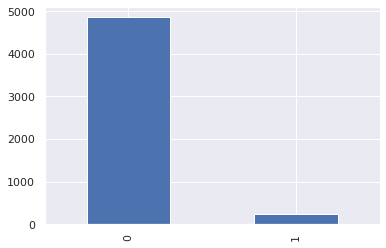

In [31]:
# show the value counts of the calsses in the target
#we can find data impalance
print(data['stroke'].value_counts())
data['stroke'].value_counts().sort_index().plot.bar()


---

# Data resampling

In [32]:
# Apply undersampling

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=0)

X_data_rus, y_data_rus = rus.fit_resample(x_data, y_data)

In [33]:
# Apply oversampling

ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
X_data_balanced, y_data_balanced = ros.fit_resample(X_data_rus, y_data_rus)

0    2490
1    2490
Name: stroke, dtype: int64


<AxesSubplot:>

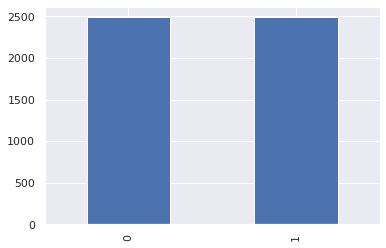

In [34]:
print(y_data_balanced.value_counts())
y_data_balanced.value_counts().sort_index().plot.bar()


---

# Split the data

#### Split the data before resampling

In [35]:
x_train1, x_test1, y_train1 , y_test1 = train_test_split(x_data,y_data, test_size=0.25 , random_state=42)

#### Split the data after resampling

In [36]:
x_train2, x_test2, y_train2 , y_test2 = train_test_split(X_data_balanced, y_data_balanced, test_size=0.25 , random_state=42)

In [37]:
print(y_train1.value_counts())
print(y_test1.value_counts())

0    3662
1     169
Name: stroke, dtype: int64
0    1198
1      80
Name: stroke, dtype: int64


<AxesSubplot:>

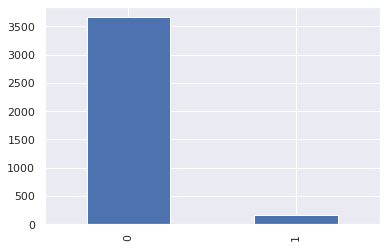

In [38]:
y_train1.value_counts().sort_index().plot.bar()

In [39]:
print(y_train2.value_counts())
print(y_test2.value_counts())

0    1870
1    1865
Name: stroke, dtype: int64
1    625
0    620
Name: stroke, dtype: int64


<AxesSubplot:>

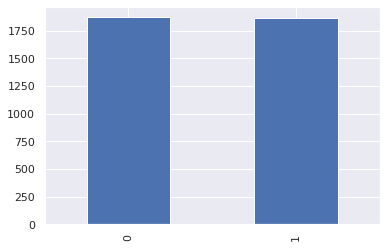

In [40]:
y_train2.value_counts().sort_index().plot.bar()

---

# Modeling before resampling

## 1. Random forest

In [41]:
# classification with random forest
classifier1 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier1.fit(x_train1, y_train1)

RandomForestClassifier(criterion='entropy', random_state=0)

In [42]:
y_pred_train_rf1 = classifier1.predict(x_train1)
acc_train_rf1 = accuracy_score(y_train1, y_pred_train_rf1)

y_pred_test_rf1 = classifier1.predict(x_test1)
acc_test_rf1 = accuracy_score(y_test1, y_pred_test_rf1)
print(acc_train_rf1)
print(acc_test_rf1)


1.0
0.9374021909233177


In [43]:
print('Precision: %.3f' % precision_score(y_test1, y_pred_test_rf1))
print('Recall: %.3f' % recall_score(y_test1, y_pred_test_rf1))
print('F-measure: %.3f' % f1_score(y_test1, y_pred_test_rf1))

Precision: 0.000
Recall: 0.000
F-measure: 0.000


In [44]:
y_pred_prob_rf1 = classifier1.predict_proba(x_test1)[:, 1]
print('ROC AUC Score:', roc_auc_score(y_test1, y_pred_prob_rf1))

ROC AUC Score: 0.7851106010016695


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

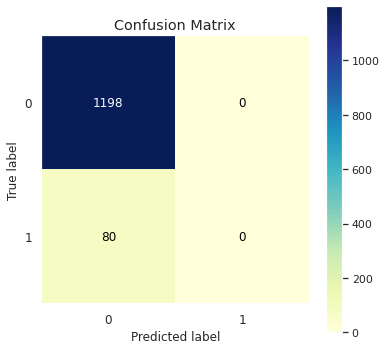

In [45]:
skplt.metrics.plot_confusion_matrix(y_test1, y_pred_test_rf1, figsize=(6,6), cmap= 'YlGnBu')

- Accuracy score is high because of imbalanced data
- ROC AUC, Precision, Recall, F-measure are bad 

## 2. XGboost

In [46]:
xgb = XGBClassifier()
xgb.fit(x_train1,y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [47]:
y_pred_train_xgb1 = xgb.predict(x_train1)
acc_train_xgb1 = accuracy_score(y_train1, y_pred_train_xgb1)

y_pred_test_xgb1 = xgb.predict(x_test1)
acc_test_xgb1 = accuracy_score(y_test1, y_pred_test_xgb1)

print(acc_train_xgb1)
print(acc_test_xgb1)

0.9994779430957974
0.9381846635367762


In [48]:
print('Precision: %.3f' % precision_score(y_test1, y_pred_test_xgb1))
print('Recall: %.3f' % recall_score(y_test1, y_pred_test_xgb1))
print('F-measure: %.3f' % f1_score(y_test1, y_pred_test_xgb1))

Precision: 0.533
Recall: 0.100
F-measure: 0.168


In [49]:
y_pred_prob_xgb1 = xgb.predict_proba(x_test1)[:, 1]
print('ROC AUC Score:', roc_auc_score(y_test1, y_pred_prob_xgb1))

ROC AUC Score: 0.7865922370617696


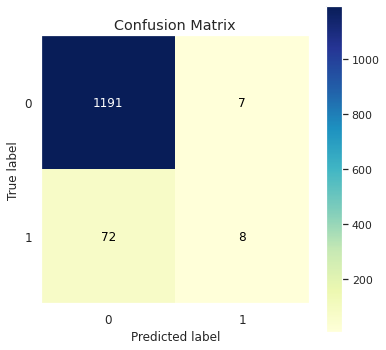

In [50]:
skplt.metrics.plot_confusion_matrix(y_test1, y_pred_test_xgb1, figsize=(6,6), cmap= 'YlGnBu');

- Accuracy score is high because of imbalanced data
- ROC AUC, Precision, Recall, F-measure are bad 

## 3. SVC

In [51]:
svc = SVC(C=100, gamma=1000, probability= True)
svc.fit(x_train1,y_train1)

SVC(C=100, gamma=1000, probability=True)

In [52]:
y_pred_train_svc1 = svc.predict(x_train1)
acc_train_svc1 = accuracy_score(y_train1, y_pred_train_svc1)

y_pred_test_svc1 = svc.predict(x_test1)
acc_test_svc1 = accuracy_score(y_test1, y_pred_test_svc1)

print(acc_train_svc1)
print(acc_test_svc1)

1.0
0.9366197183098591


In [53]:
print('Precision: %.3f' % precision_score(y_test1, y_pred_test_svc1))
print('Recall: %.3f' % recall_score(y_test1, y_pred_test_svc1))
print('F-measure: %.3f' % f1_score(y_test1, y_pred_test_svc1))

Precision: 0.000
Recall: 0.000
F-measure: 0.000


In [54]:
y_pred_prob_svc1 = svc.predict_proba(x_test1)[:, 1]
print('ROC AUC Score:', roc_auc_score(y_test1, y_pred_prob_svc1))

ROC AUC Score: 0.6837698247078464


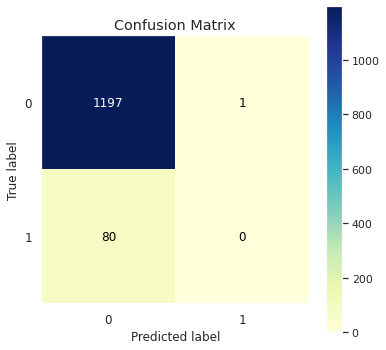

In [55]:
skplt.metrics.plot_confusion_matrix(y_test1, y_pred_test_svc1, figsize=(6,6), cmap= 'YlGnBu');

- Accuracy score is high because of imbalanced data
- ROC AUC, Precision, Recall, F-measure are so bad 

---

# Modeling After resampling

## 1. Random forest

In [56]:
# classification with random forest

classifier2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier2.fit(x_train2, y_train2)


RandomForestClassifier(criterion='entropy', random_state=0)

In [57]:
y_pred_train_rf2 = classifier2.predict(x_train2)
acc_train_rf2 = accuracy_score(y_train2, y_pred_train_rf2)

y_pred_test_rf2 = classifier2.predict(x_test2)
acc_test_rf2 = accuracy_score(y_test2, y_pred_test_rf2)
print(acc_train_rf2)
print(acc_test_rf2)


1.0
0.9622489959839358


In [58]:
print('Precision: %.3f' % precision_score(y_test2, y_pred_test_rf2))
print('Recall: %.3f' % recall_score(y_test2, y_pred_test_rf2))
print('F-measure: %.3f' % f1_score(y_test2, y_pred_test_rf2))

Precision: 0.930
Recall: 1.000
F-measure: 0.964


In [59]:
y_pred_prob_rf2 = classifier2.predict_proba(x_test2)[:, 1]
print('ROC AUC Score:', roc_auc_score(y_test2, y_pred_prob_rf2))

ROC AUC Score: 0.9999922580645161


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

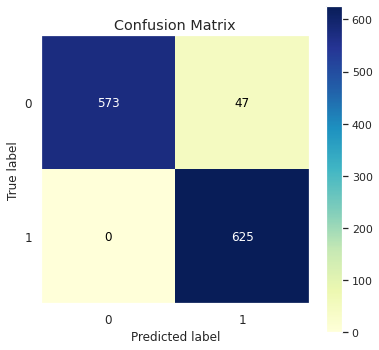

In [60]:
skplt.metrics.plot_confusion_matrix(y_test2, y_pred_test_rf2, figsize=(6,6), cmap= 'YlGnBu')

- Accuracy score is high
- Precision, Recall, F-measure are perfect
- ROC AUC score is perfect

## 2. XGBoost

In [61]:
xgb = XGBClassifier()
xgb.fit(x_train2,y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [62]:
y_pred_train_xgb2 = xgb.predict(x_train2)
acc_train_xgb2 = accuracy_score(y_train2, y_pred_train_xgb2)

y_pred_test_xgb2 = xgb.predict(x_test2)
acc_test_xgb2 = accuracy_score(y_test2, y_pred_test_xgb2)

print(acc_train_xgb2)
print(acc_test_xgb2)

0.9994645247657296
0.9461847389558233


In [63]:
print('Precision: %.3f' % precision_score(y_test2, y_pred_test_xgb2))
print('Recall: %.3f' % recall_score(y_test2, y_pred_test_xgb2))
print('F-measure: %.3f' % f1_score(y_test2, y_pred_test_xgb2))

Precision: 0.903
Recall: 1.000
F-measure: 0.949


In [64]:
y_pred_prob_xgb2 = xgb.predict_proba(x_test2)[:, 1]
print('ROC AUC Score:', roc_auc_score(y_test2, y_pred_prob_xgb2))

ROC AUC Score: 0.9926322580645162


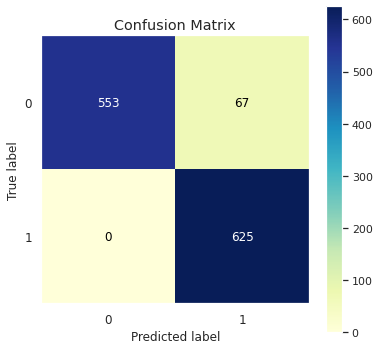

In [65]:
skplt.metrics.plot_confusion_matrix(y_test2, y_pred_test_xgb2, figsize=(6,6), cmap= 'YlGnBu');

- Accuracy score is high
- Precision, Recall, F-measure are perfect
- ROC AUC score is perfect

## 3. SVC

In [66]:
svc = SVC(C=100, gamma=1000 ,probability= True)
svc.fit(x_train2,y_train2)


SVC(C=100, gamma=1000, probability=True)

In [67]:
y_pred_train_svc2 = svc.predict(x_train2)
acc_train_svc2 = accuracy_score(y_train2, y_pred_train_svc2)

y_pred_test_svc2 = svc.predict(x_test2)
acc_test_svc2 = accuracy_score(y_test2, y_pred_test_svc2)

print(acc_train_svc2)
print(acc_test_svc2)

1.0
0.9967871485943776


In [68]:
print('Precision: %.3f' % precision_score(y_test2, y_pred_test_svc2))
print('Recall: %.3f' % recall_score(y_test2, y_pred_test_svc2))
print('F-measure: %.3f' % f1_score(y_test2, y_pred_test_svc2))

Precision: 0.994
Recall: 1.000
F-measure: 0.997


In [69]:
y_pred_prob_svc2 = svc.predict_proba(x_test2)[:, 1]
print('ROC AUC Score:', roc_auc_score(y_test2, y_pred_prob_svc2))

ROC AUC Score: 1.0


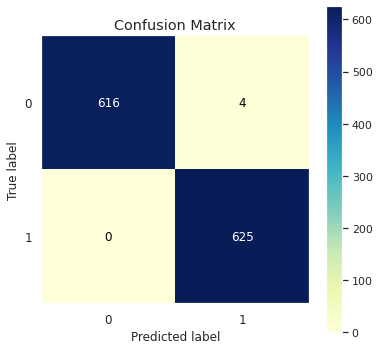

In [70]:
skplt.metrics.plot_confusion_matrix(y_test2, y_pred_test_svc2, figsize=(6,6), cmap= 'YlGnBu');

- Accuracy score is high
- Precision, Recall, F-measure are perfect
- ROC AUC score is perfect

# Compare between algorithms

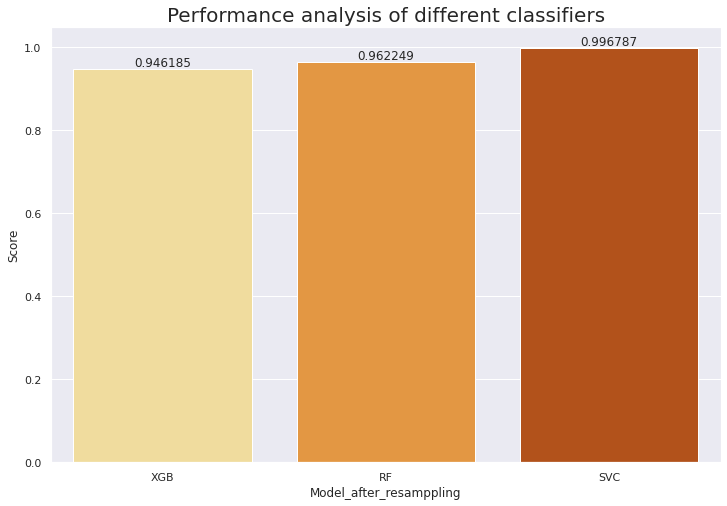

In [71]:
Performance = pd.DataFrame(
    data = {
        'Model_after_resamppling': ['XGB','RF','SVC'],
        'Score': [accuracy_score(y_test2, y_pred_test_xgb2),
                  accuracy_score(y_test2, y_pred_test_rf2),
                  accuracy_score(y_test2, y_pred_test_svc2)],
        
        'ROC_AUC_Score': [roc_auc_score(y_test2, y_pred_prob_xgb2),
                          roc_auc_score(y_test2, y_pred_prob_rf2), 
                          roc_auc_score(y_test2, y_pred_prob_svc2)]
    }
)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Model_after_resamppling", y="Score", data= Performance, palette="YlOrBr")
ax.bar_label(ax.containers[0])
plt.title('Performance analysis of different classifiers',fontsize=20)
plt.show()

In [72]:
Performance.sort_values('ROC_AUC_Score',ascending=False)

,Model_after_resamppling,Score,ROC_AUC_Score
2,SVC,0.996787,1.000000
1,RF,0.962249,0.999992
0,XGB,0.946185,0.992632


# Conclusion

**1. Because of imbalanced data the basic accuracy score was misleading but when I used the right evaluation metrics like Precision/Specificity, Recall/Sensitivity, F1 score, and AUC they were very bad**

**2. After the preprocessing and resampling of the data, it became balanced and more accurate**

**3. There is clear differences in the metrics between applying the algorithms before and after resampling**